# Model Performance Analysis

This notebook evaluates and compares the performance of the different LLM prediction models, both with and without PPO adjustments.

## 1. Import Libraries

In [81]:
import pandas as pd
import numpy as np
import json

def load_jsonl(filepath):
    """Load JSONL file"""
    data = []
    with open(filepath, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return data

def parse_prompt_data(prompt_text):
    """Extract key information from prompt"""
    lines = prompt_text.split('\n')
    data = {}
    
    for line in lines:
        if 'TICKER:' in line:
            data['ticker'] = line.split('TICKER:')[1].strip()
        elif 'DATE:' in line:
            data['date'] = line.split('DATE:')[1].strip()
        elif 'RECENT CLOSING PRICES' in line:
            if ':' in line:
                prices_part = line.split(':', 1)[1].strip()
                if '(' in prices_part:
                    prices_part = prices_part.split('(')[0].strip()
                try:
                    data['recent_prices'] = [float(p.strip()) for p in prices_part.split(',') if p.strip()]
                except (ValueError, AttributeError): # Handle cases where prices are not valid
                    data['recent_prices'] = []
    
    return data

print("Libraries and helper functions imported.")

Libraries and helper functions imported.


## 2. Load Prediction Data

In [82]:
try:
    # --- Load PPO-adjusted predictions ---
    # Original PPO model
    inference_ppo_df = pd.read_csv('../results/test_predictions_with_ppo.csv')
    # Optimized PPO model (Paper's Method)
    paper_ppo_df = pd.read_csv('../results/test_predictions_with_ppo_optimized.csv')

    # --- Load raw LLM predictions (without PPO) ---
    with open('../results/llm_predictions_checkpoint.json', 'r') as f:
        inference_raw = json.load(f)
    with open('../results/llm_predictions_justification_checkpoint.json', 'r') as f:
        justification_raw = json.load(f)
    with open('../results/llm_predictions_cot_checkpoint.json', 'r') as f:
        cot_raw = json.load(f)
    
    # --- Load RNN/LSTM predictions ---
    rnn_lstm_df = pd.read_csv('../results/rnn_lstm_predictions.csv')
    rnn_lstm_df['date'] = pd.to_datetime(rnn_lstm_df['date'])
        
    print("All prediction files loaded successfully.")
    print(f"RNN/LSTM predictions shape: {rnn_lstm_df.shape}")
    
except FileNotFoundError as e:
    print(f"Error loading data: {e}. Please ensure all inference notebooks have been run.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

All prediction files loaded successfully.
RNN/LSTM predictions shape: (2477, 6)


## 3. Calculate and Compare MAE

In [83]:
def calculate_mae_from_df(df, pred_col, actual_col='actual_price'):
    """Calculates the Mean Absolute Error from a DataFrame."""
    return np.mean(np.abs(df[pred_col] - df[actual_col]))

def calculate_mae_from_raw(raw_data):
    """Calculates the Mean Absolute Error from raw checkpoint data, handling None values."""
    valid_predictions = []
    valid_actuals = []
    
    llm_results = raw_data.get('llm_results', [])
    actual_prices = raw_data.get('actual_prices', [])
    
    num_samples = min(len(llm_results), len(actual_prices))

    for i in range(num_samples):
        prediction = llm_results[i].get('predicted_close')
        actual = actual_prices[i]
        
        if prediction is not None:
            valid_predictions.append(float(prediction))
            valid_actuals.append(float(actual))
            
    if not valid_predictions:
        return np.nan

    return np.mean(np.abs(np.array(valid_predictions) - np.array(valid_actuals)))

results = {}

# RNN/LSTM models
if 'rnn_lstm_df' in locals():
    results['RNN'] = {'MAE': calculate_mae_from_df(rnn_lstm_df, 'rnn_prediction')}
    results['LSTM'] = {'MAE': calculate_mae_from_df(rnn_lstm_df, 'lstm_prediction')}

# PPO models
if 'inference_ppo_df' in locals():
    results['Inference (PPO Original)'] = {'MAE': calculate_mae_from_df(inference_ppo_df, 'ppo_adjusted_prediction')}
if 'paper_ppo_df' in locals():
    results['Inference (PPO Paper)'] = {'MAE': calculate_mae_from_df(paper_ppo_df, 'ppo_adjusted_prediction')}

# Raw LLM models
if 'inference_raw' in locals():
    results['Inference (LLM only)'] = {'MAE': calculate_mae_from_raw(inference_raw)}
if 'justification_raw' in locals():
    results['Justification (LLM only)'] = {'MAE': calculate_mae_from_raw(justification_raw)}
if 'cot_raw' in locals():
    results['CoT (LLM only)'] = {'MAE': calculate_mae_from_raw(cot_raw)}

if results:
    results_df = pd.DataFrame(results).T
    results_df = results_df.sort_values(by='MAE', ascending=True)
    
    print("Model Performance Comparison (MAE):")
    display(results_df)
else:
    print("No data to compare. Please check the file loading step.")

Model Performance Comparison (MAE):


,MAE
Justification (LLM only),10.379693
CoT (LLM only),10.971941
RNN,27.099114
LSTM,33.837561
Inference (LLM only),62.115208
Inference (PPO Paper),62.391258
Inference (PPO Original),64.599908


## 4. Calculate and Compare MAPE

In [84]:
def calculate_mape_from_df(df, pred_col, actual_col='actual_price'):
    """Calculates the Mean Absolute Percentage Error from a DataFrame."""
    return np.mean(np.abs((df[actual_col] - df[pred_col]) / df[actual_col])) * 100

def calculate_mape_from_raw(raw_data):
    """Calculates the Mean Absolute Percentage Error from raw checkpoint data."""
    valid_predictions = []
    valid_actuals = []
    
    llm_results = raw_data.get('llm_results', [])
    actual_prices = raw_data.get('actual_prices', [])
    
    num_samples = min(len(llm_results), len(actual_prices))

    for i in range(num_samples):
        prediction = llm_results[i].get('predicted_close')
        actual = actual_prices[i]
        
        if prediction is not None and actual is not None and actual != 0:
            valid_predictions.append(float(prediction))
            valid_actuals.append(float(actual))
            
    if not valid_predictions:
        return np.nan

    return np.mean(np.abs((np.array(valid_actuals) - np.array(valid_predictions)) / np.array(valid_actuals))) * 100

mape_results = {}

# RNN/LSTM models
if 'rnn_lstm_df' in locals():
    mape_results['RNN'] = {'MAPE (%)': calculate_mape_from_df(rnn_lstm_df, 'rnn_prediction')}
    mape_results['LSTM'] = {'MAPE (%)': calculate_mape_from_df(rnn_lstm_df, 'lstm_prediction')}

# PPO models
if 'inference_ppo_df' in locals():
    mape_results['Inference (PPO Original)'] = {'MAPE (%)': calculate_mape_from_df(inference_ppo_df, 'ppo_adjusted_prediction')}
if 'paper_ppo_df' in locals():
    mape_results['Inference (PPO Paper)'] = {'MAPE (%)': calculate_mape_from_df(paper_ppo_df, 'ppo_adjusted_prediction')}

# Raw LLM models
if 'inference_raw' in locals():
    mape_results['Inference (LLM only)'] = {'MAPE (%)': calculate_mape_from_raw(inference_raw)}
if 'justification_raw' in locals():
    mape_results['Justification (LLM only)'] = {'MAPE (%)': calculate_mape_from_raw(justification_raw)}
if 'cot_raw' in locals():
    mape_results['CoT (LLM only)'] = {'MAPE (%)': calculate_mape_from_raw(cot_raw)}

if mape_results:
    mape_df = pd.DataFrame(mape_results).T
    mape_df = mape_df.sort_values(by='MAPE (%)', ascending=True)
    
    print("Model Performance Comparison (MAPE %):")
    display(mape_df)
else:
    print("No data to compare. Please check the file loading step.")

Model Performance Comparison (MAPE %):


,MAPE (%)
Justification (LLM only),1.329401
CoT (LLM only),1.365380
RNN,4.763616
LSTM,6.345277
Inference (LLM only),6.789956
Inference (PPO Paper),6.886098
Inference (PPO Original),7.320734


## 5. Segmented Performance Analysis (by Volatility)

Segmented Performance by Market Volatility (MAPE %):


,MAPE (%)
RNN (High Vol),5.054897
RNN (Low Vol),4.472569
LSTM (High Vol),6.119108
LSTM (Low Vol),6.571263
Inference (PPO Paper) (High Vol),10.496539
Inference (PPO Paper) (Low Vol),3.278572
Inference (LLM only) (High Vol),10.478713
Inference (LLM only) (Low Vol),3.104176
Justification (LLM only) (High Vol),1.466948
Justification (LLM only) (Low Vol),1.191965


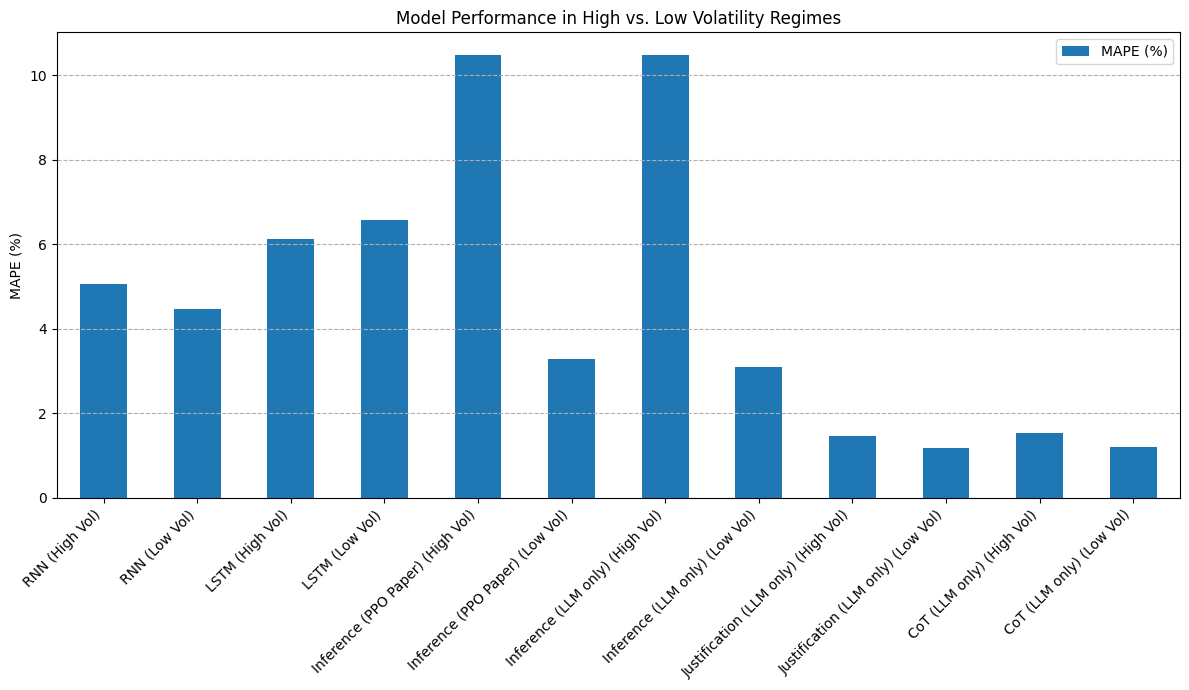

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
import ast

def analyze_by_volatility(df, model_name, results_dict, pred_col='predicted_close'):
    """Calculates MAPE for high and low volatility regimes."""
    df['volatility'] = df['recent_prices'].apply(lambda x: np.std(np.diff(x) / x[:-1]) if (isinstance(x, list) and len(x) > 1) else 0)
    
    volatility_threshold = df['volatility'].median()

    if len(df['volatility'].unique()) == 1:
        results_dict[f'{model_name} (High Vol)'] = {'MAPE (%)': np.nan}
        results_dict[f'{model_name} (Low Vol)'] = {'MAPE (%)': calculate_mape_from_df(df, pred_col)}
        return

    high_vol_df = df[df['volatility'] > volatility_threshold]
    low_vol_df = df[df['volatility'] <= volatility_threshold]
    
    results_dict[f'{model_name} (High Vol)'] = {'MAPE (%)': calculate_mape_from_df(high_vol_df, pred_col)}
    results_dict[f'{model_name} (Low Vol)'] = {'MAPE (%)': calculate_mape_from_df(low_vol_df, pred_col)}

try:
    ground_truth_data = load_jsonl('../finetune_paper/test.jsonl')
    base_test_df = pd.DataFrame([parse_prompt_data(item['prompt']) for item in ground_truth_data])
except Exception as e:
    print(f"Could not load base data: {e}. Volatility analysis will be skipped.")
    base_test_df = None

volatility_results = {}

# --- Analyze RNN/LSTM Models ---
if 'rnn_lstm_df' in locals():
    # Make a copy to avoid modifying the original
    rnn_lstm_df_vol = rnn_lstm_df.copy()
    # Convert string representation of list to actual list if needed
    if isinstance(rnn_lstm_df_vol['recent_prices'].iloc[0], str):
        rnn_lstm_df_vol['recent_prices'] = rnn_lstm_df_vol['recent_prices'].apply(ast.literal_eval)
    analyze_by_volatility(rnn_lstm_df_vol, 'RNN', volatility_results, pred_col='rnn_prediction')
    
    rnn_lstm_df_vol = rnn_lstm_df.copy()
    if isinstance(rnn_lstm_df_vol['recent_prices'].iloc[0], str):
        rnn_lstm_df_vol['recent_prices'] = rnn_lstm_df_vol['recent_prices'].apply(ast.literal_eval)
    analyze_by_volatility(rnn_lstm_df_vol, 'LSTM', volatility_results, pred_col='lstm_prediction')

if base_test_df is not None:
    # --- Analyze PPO (Paper) Model ---
    if 'paper_ppo_df' in locals():
        # The CSV already has the necessary columns, just merge recent_prices
        paper_ppo_df['recent_prices'] = base_test_df['recent_prices']
        analyze_by_volatility(paper_ppo_df, 'Inference (PPO Paper)', volatility_results, pred_col='ppo_adjusted_prediction')

    # --- Analyze Inference (LLM only) Model ---
    if 'inference_raw' in locals():
        inference_df = pd.DataFrame(inference_raw['llm_results'])
        inference_df['actual_price'] = inference_raw['actual_prices']
        inference_df['recent_prices'] = base_test_df['recent_prices']
        analyze_by_volatility(inference_df, 'Inference (LLM only)', volatility_results)

    # --- Analyze Justification Model ---
    if 'justification_raw' in locals():
        justification_df = pd.DataFrame(justification_raw['llm_results'])
        justification_df['actual_price'] = justification_raw['actual_prices']
        justification_df['recent_prices'] = base_test_df['recent_prices']
        analyze_by_volatility(justification_df, 'Justification (LLM only)', volatility_results)

    # --- Analyze CoT Model ---
    if 'cot_raw' in locals():
        cot_df = pd.DataFrame(cot_raw['llm_results'])
        cot_df['actual_price'] = cot_raw['actual_prices']
        cot_df['recent_prices'] = base_test_df['recent_prices']
        analyze_by_volatility(cot_df, 'CoT (LLM only)', volatility_results)

if volatility_results:
    volatility_df = pd.DataFrame(volatility_results).T
    
    print("Segmented Performance by Market Volatility (MAPE %):")
    display(volatility_df)
    
    volatility_df.plot(kind='bar', figsize=(12, 7))
    plt.title('Model Performance in High vs. Low Volatility Regimes')
    plt.ylabel('MAPE (%)')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()
else:
    print("Could not perform volatility analysis. Data not available.")

## 6. Comprehensive Forecasting Quality Metrics

This section evaluates models using multiple forecasting metrics that highlight prediction accuracy without trading simulation. These metrics are standard in forecasting research and provide a comprehensive view of model performance.

In [86]:
from sklearn.metrics import r2_score

def evaluate_prediction_quality(predictions, actuals, model_name):
    """
    Comprehensive forecasting quality evaluation.
    
    Metrics included:
    - MAE: Mean Absolute Error
    - MAPE: Mean Absolute Percentage Error
    - RMSE: Root Mean Squared Error
    - R²: Coefficient of Determination (variance explained)
    - SMAPE: Symmetric MAPE (bounded 0-100%)
    - MSLE: Mean Squared Log Error
    - MDA: Mean Directional Accuracy
    - NRMSE: Normalized RMSE (as % of mean)
    - Mean Bias: Average over/under prediction
    """
    # Remove None values
    pred_array = np.array([p for p in predictions if p is not None], dtype=float)
    actual_array = np.array([a for a, p in zip(actuals, predictions) if p is not None], dtype=float)
    
    if len(pred_array) == 0:
        return None
    
    # 1. Mean Absolute Error (MAE)
    mae = np.mean(np.abs(pred_array - actual_array))
    
    # 2. Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((actual_array - pred_array) / actual_array)) * 100
    
    # 3. Root Mean Squared Error (RMSE)
    rmse = np.sqrt(np.mean((pred_array - actual_array)**2))
    
    # 4. R² Score (Coefficient of Determination)
    r2 = r2_score(actual_array, pred_array)
    
    # 5. Mean Squared Log Error (MSLE) - good for right-skewed data
    msle = np.mean((np.log1p(actual_array) - np.log1p(pred_array))**2)
    
    # 6. Symmetric MAPE (SMAPE) - bounded between 0-100%
    smape = np.mean(2 * np.abs(pred_array - actual_array) / (np.abs(actual_array) + np.abs(pred_array))) * 100
    
    # 7. Mean Directional Accuracy (MDA) - what % of directions are correct
    if len(pred_array) > 1:
        pred_direction = np.diff(pred_array)
        actual_direction = np.diff(actual_array)
        mda = np.mean(np.sign(pred_direction) == np.sign(actual_direction)) * 100
    else:
        mda = np.nan
    
    # 8. Normalized RMSE (as % of mean actual price)
    nrmse = (rmse / np.mean(actual_array)) * 100
    
    # 9. Mean Bias Error (MBE) - shows if model over/under predicts
    mbe = np.mean(pred_array - actual_array)
    
    # 10. Max Error
    max_error = np.max(np.abs(pred_array - actual_array))
    
    return {
        'Model': model_name,
        'MAE': mae,
        'MAPE (%)': mape,
        'RMSE': rmse,
        'NRMSE (%)': nrmse,
        'R² Score': r2,
        'SMAPE (%)': smape,
        'MSLE': msle,
        'MDA (%)': mda,
        'Mean Bias': mbe,
        'Max Error': max_error,
        'N': len(pred_array)
    }

print("✓ Forecasting quality evaluation functions defined.")

✓ Forecasting quality evaluation functions defined.


In [87]:
# Evaluate all models with comprehensive metrics
forecasting_results = []

# RNN/LSTM Models
if 'rnn_lstm_df' in locals() and rnn_lstm_df is not None:
    rnn_result = evaluate_prediction_quality(
        rnn_lstm_df['rnn_prediction'].values,
        rnn_lstm_df['actual_price'].values,
        'RNN'
    )
    if rnn_result:
        forecasting_results.append(rnn_result)
    
    lstm_result = evaluate_prediction_quality(
        rnn_lstm_df['lstm_prediction'].values,
        rnn_lstm_df['actual_price'].values,
        'LSTM'
    )
    if lstm_result:
        forecasting_results.append(lstm_result)

# LLM Models - Inference
if 'inference_raw' in locals() and inference_raw is not None:
    inference_result = evaluate_prediction_quality(
        [r.get('predicted_close') for r in inference_raw['llm_results']],
        inference_raw['actual_prices'],
        'Inference (LLM only)'
    )
    if inference_result:
        forecasting_results.append(inference_result)

# LLM Models - Justification
if 'justification_raw' in locals() and justification_raw is not None:
    justification_result = evaluate_prediction_quality(
        [r.get('predicted_close') for r in justification_raw['llm_results']],
        justification_raw['actual_prices'],
        'Justification (LLM only)'
    )
    if justification_result:
        forecasting_results.append(justification_result)

# LLM Models - CoT
if 'cot_raw' in locals() and cot_raw is not None:
    cot_result = evaluate_prediction_quality(
        [r.get('predicted_close') for r in cot_raw['llm_results']],
        cot_raw['actual_prices'],
        'CoT (LLM only)'
    )
    if cot_result:
        forecasting_results.append(cot_result)

# PPO-adjusted Models
if 'inference_ppo_df' in locals() and inference_ppo_df is not None:
    inference_ppo_result = evaluate_prediction_quality(
        inference_ppo_df['ppo_adjusted_prediction'].values,
        inference_ppo_df['actual_price'].values,
        'Inference (PPO Original)'
    )
    if inference_ppo_result:
        forecasting_results.append(inference_ppo_result)

if 'paper_ppo_df' in locals() and paper_ppo_df is not None:
    paper_ppo_result = evaluate_prediction_quality(
        paper_ppo_df['ppo_adjusted_prediction'].values,
        paper_ppo_df['actual_price'].values,
        'Inference (PPO Paper)'
    )
    if paper_ppo_result:
        forecasting_results.append(paper_ppo_result)

# Create comparison DataFrame
if forecasting_results:
    forecasting_df = pd.DataFrame(forecasting_results)
    
    # Sort by MAPE (lower is better)
    forecasting_df = forecasting_df.sort_values('MAPE (%)', ascending=True)

    display(forecasting_df[['Model', 'MAPE (%)', 'RMSE', 'NRMSE (%)', 'R² Score', 'SMAPE (%)', 'MDA (%)', 'Mean Bias', 'N']])
    print("=" * 130)
else:
    print("Could not compute forecasting metrics. Data not available.")

,Model,MAPE (%),RMSE,NRMSE (%),R² Score,SMAPE (%),MDA (%),Mean Bias,N
3,Justification (LLM only),1.329401,26.651149,3.950030,0.999315,1.330613,96.688207,-1.491620,2477
4,CoT (LLM only),1.365380,28.391129,4.226272,0.999220,1.368468,96.926230,-2.315376,2441
0,RNN,4.763616,67.781504,10.046057,0.995568,4.611238,96.890145,-15.298066,2477
1,LSTM,6.345277,81.286454,12.047658,0.993627,6.593091,97.294023,2.599443,2477
2,Inference (LLM only),6.789956,313.821428,46.512216,0.905006,11.785919,88.489499,-43.882267,2477
6,Inference (PPO Paper),6.886098,313.798165,46.508768,0.905020,11.900116,88.489499,-50.181799,2477
5,Inference (PPO Original),7.320734,314.223206,46.571764,0.904762,12.355689,88.489499,-56.481319,2477


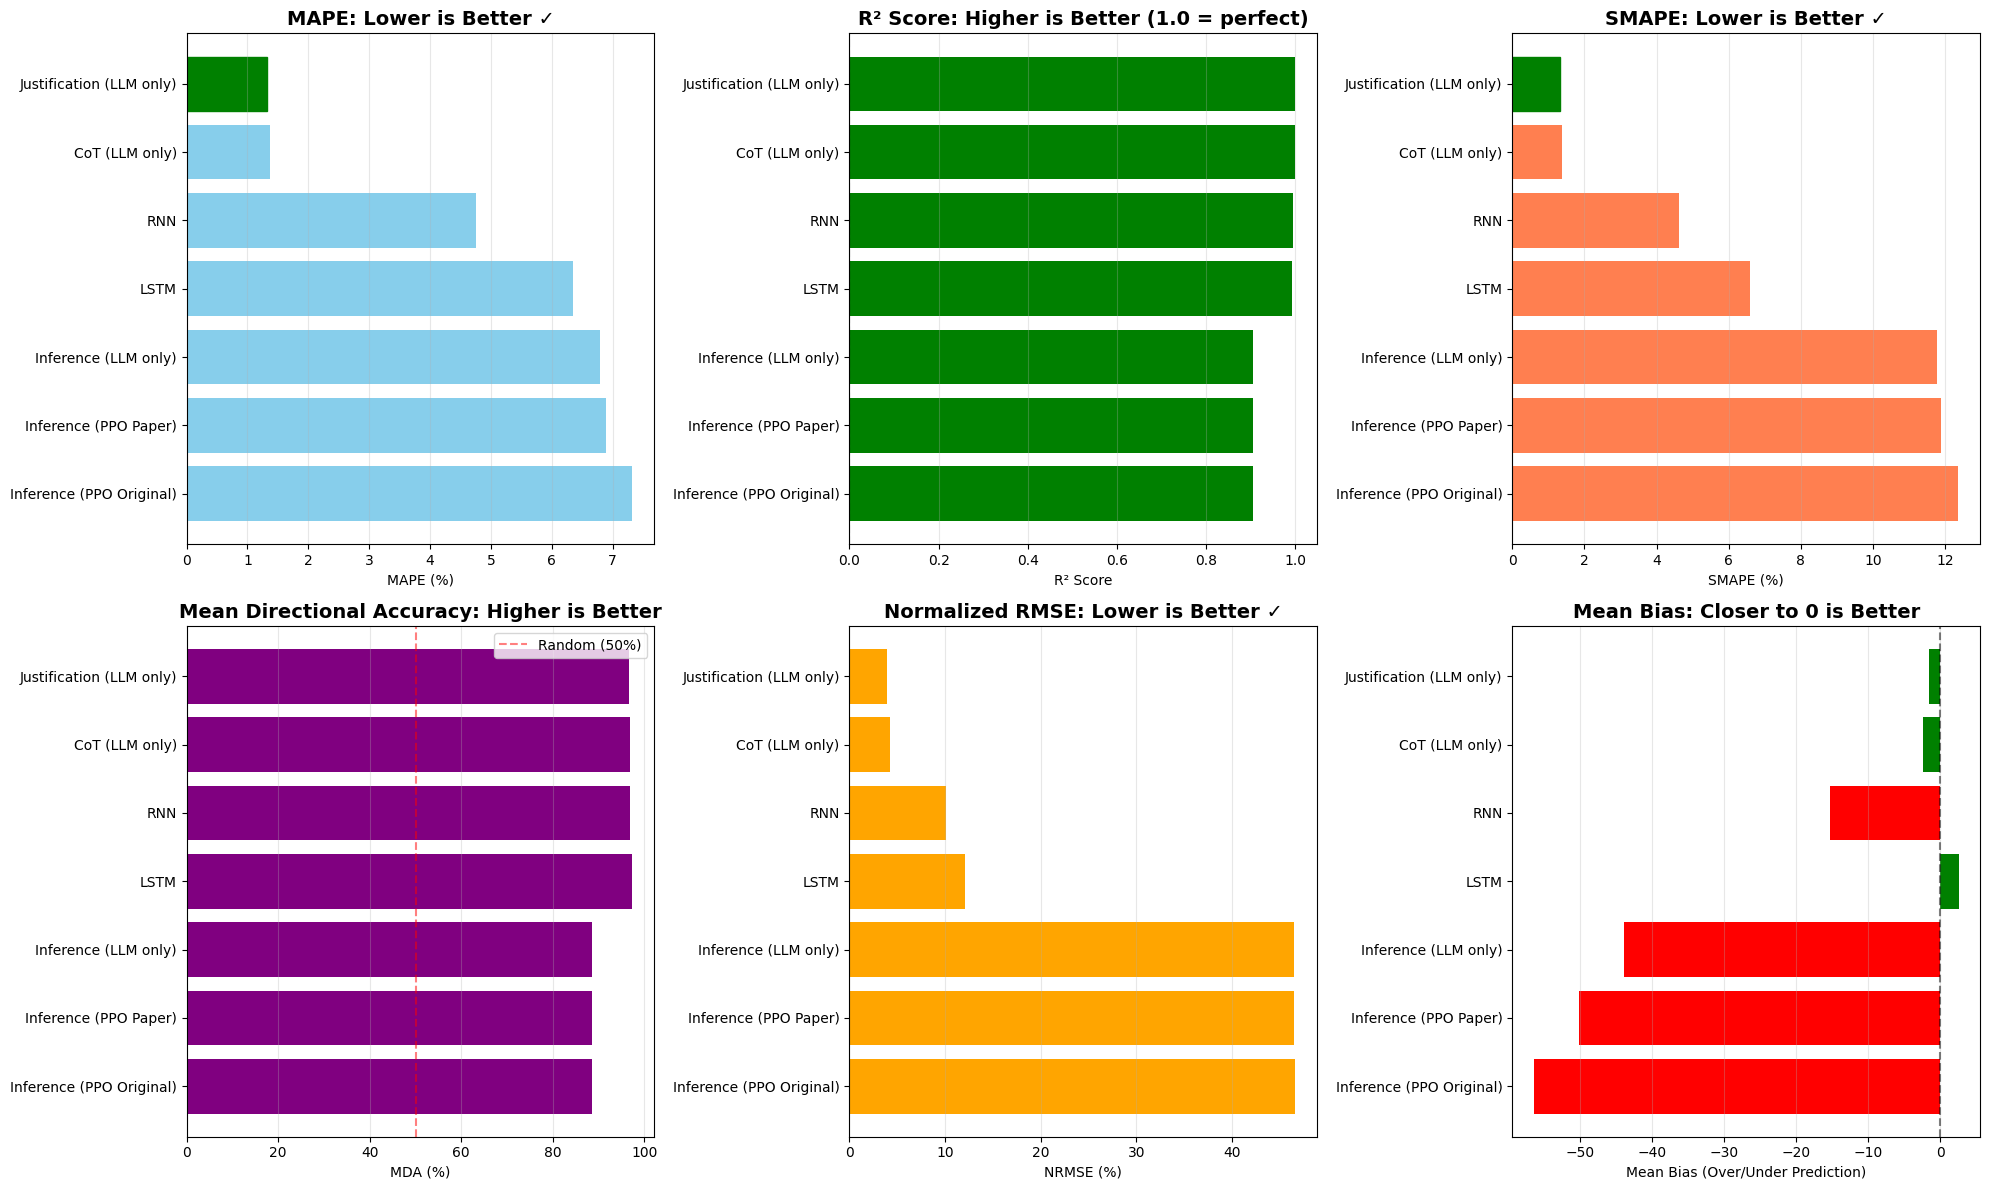

✓ Visualizations saved to '../results/comprehensive_forecasting_metrics.png'


In [88]:
# Visualize comprehensive forecasting metrics
if forecasting_results:
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # 1. MAPE - Lower is better
    axes[0, 0].barh(forecasting_df['Model'], forecasting_df['MAPE (%)'], color='skyblue')
    axes[0, 0].set_title('MAPE: Lower is Better ✓', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('MAPE (%)')
    axes[0, 0].invert_yaxis()
    axes[0, 0].grid(axis='x', alpha=0.3)
    # Highlight best
    best_idx = forecasting_df['MAPE (%)'].idxmin()
    axes[0, 0].patches[list(forecasting_df.index).index(best_idx)].set_color('green')
    
    # 2. R² Score - Higher is better
    colors_r2 = ['green' if x > 0 else 'red' for x in forecasting_df['R² Score']]
    axes[0, 1].barh(forecasting_df['Model'], forecasting_df['R² Score'], color=colors_r2)
    axes[0, 1].set_title('R² Score: Higher is Better (1.0 = perfect)', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('R² Score')
    axes[0, 1].invert_yaxis()
    axes[0, 1].axvline(x=0, color='black', linestyle='--', alpha=0.5)
    axes[0, 1].grid(axis='x', alpha=0.3)
    
    # 3. SMAPE - Lower is better
    axes[0, 2].barh(forecasting_df['Model'], forecasting_df['SMAPE (%)'], color='coral')
    axes[0, 2].set_title('SMAPE: Lower is Better ✓', fontsize=14, fontweight='bold')
    axes[0, 2].set_xlabel('SMAPE (%)')
    axes[0, 2].invert_yaxis()
    axes[0, 2].grid(axis='x', alpha=0.3)
    # Highlight best
    best_idx = forecasting_df['SMAPE (%)'].idxmin()
    axes[0, 2].patches[list(forecasting_df.index).index(best_idx)].set_color('green')
    
    # 4. Mean Directional Accuracy - Higher is better
    axes[1, 0].barh(forecasting_df['Model'], forecasting_df['MDA (%)'], color='purple')
    axes[1, 0].set_title('Mean Directional Accuracy: Higher is Better', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('MDA (%)')
    axes[1, 0].invert_yaxis()
    axes[1, 0].axvline(x=50, color='red', linestyle='--', alpha=0.5, label='Random (50%)')
    axes[1, 0].grid(axis='x', alpha=0.3)
    axes[1, 0].legend()
    
    # 5. NRMSE - Lower is better
    axes[1, 1].barh(forecasting_df['Model'], forecasting_df['NRMSE (%)'], color='orange')
    axes[1, 1].set_title('Normalized RMSE: Lower is Better ✓', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('NRMSE (%)')
    axes[1, 1].invert_yaxis()
    axes[1, 1].grid(axis='x', alpha=0.3)
    
    # 6. Mean Bias Error - Closer to 0 is better
    colors_bias = ['red' if abs(x) > 5 else 'green' for x in forecasting_df['Mean Bias']]
    axes[1, 2].barh(forecasting_df['Model'], forecasting_df['Mean Bias'], color=colors_bias)
    axes[1, 2].set_title('Mean Bias: Closer to 0 is Better', fontsize=14, fontweight='bold')
    axes[1, 2].set_xlabel('Mean Bias (Over/Under Prediction)')
    axes[1, 2].invert_yaxis()
    axes[1, 2].axvline(x=0, color='black', linestyle='--', alpha=0.5)
    axes[1, 2].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../results/comprehensive_forecasting_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Visualizations saved to '../results/comprehensive_forecasting_metrics.png'")

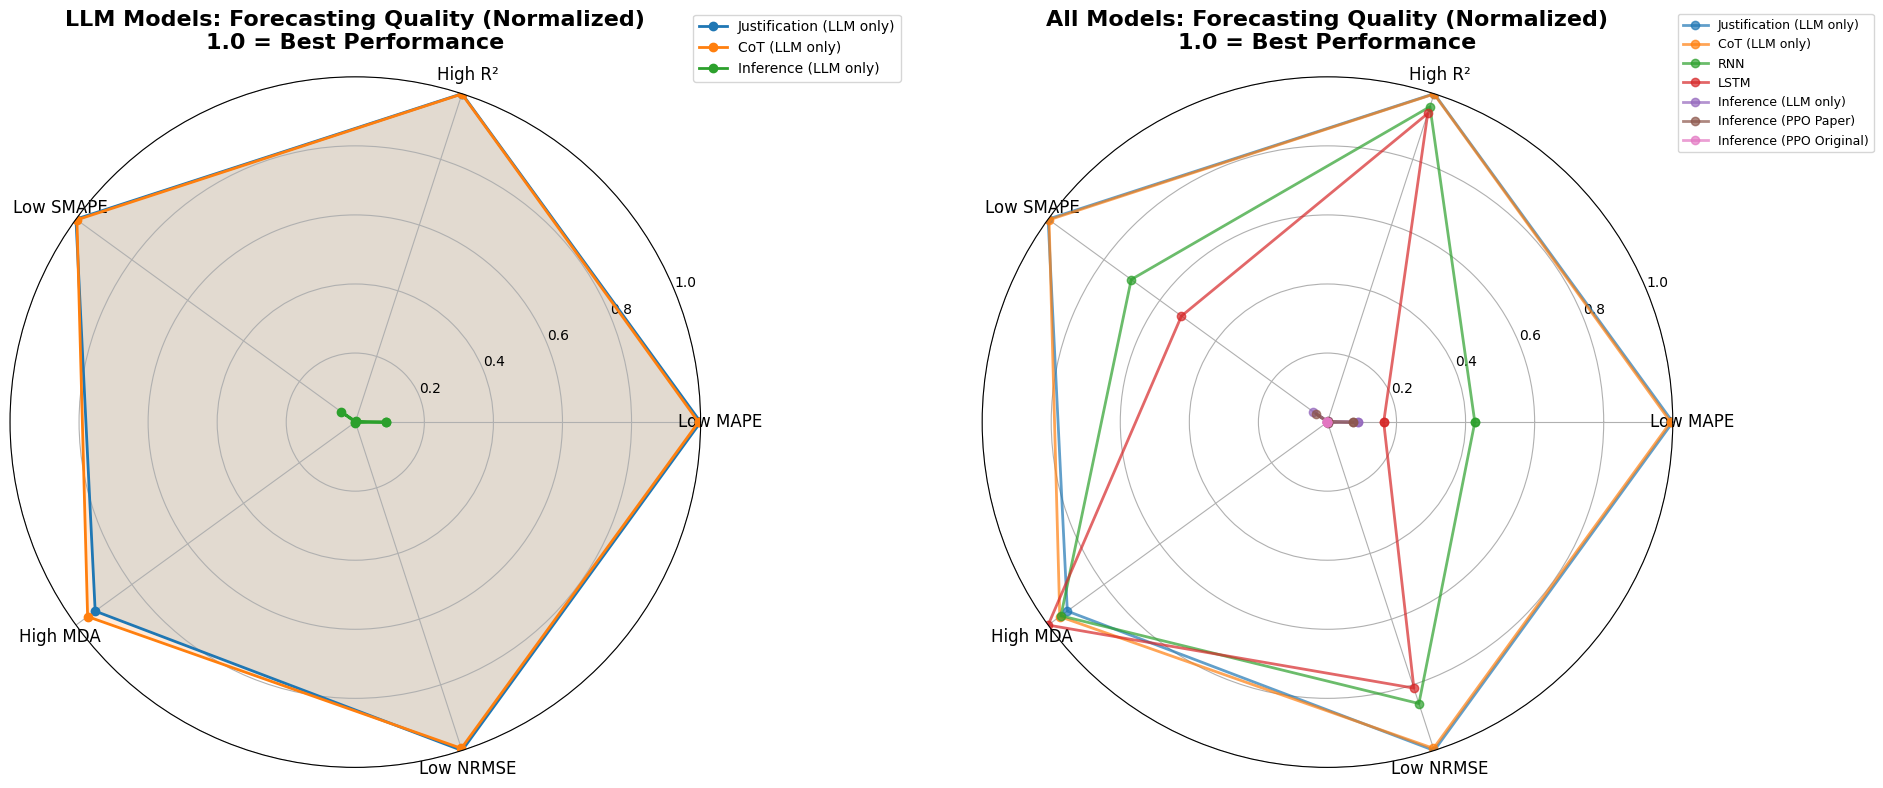

✓ Radar chart saved to '../results/forecasting_radar_chart.png'


In [89]:
# Create radar chart for LLM models comparison
if forecasting_results:
    from math import pi
    
    def normalize_metric(values, higher_is_better=False):
        """Normalize to 0-1 scale where 1 is best"""
        if higher_is_better:
            return (values - values.min()) / (values.max() - values.min() + 1e-10)
        else:
            return 1 - (values - values.min()) / (values.max() - values.min() + 1e-10)
    
    # Prepare data for radar chart
    radar_data = forecasting_df[['Model', 'MAPE (%)', 'R² Score', 'SMAPE (%)', 'MDA (%)', 'NRMSE (%)']].copy()
    
    # Normalize metrics (1 = best)
    radar_data['MAPE_norm'] = normalize_metric(radar_data['MAPE (%)'], higher_is_better=False)
    radar_data['R2_norm'] = normalize_metric(radar_data['R² Score'], higher_is_better=True)
    radar_data['SMAPE_norm'] = normalize_metric(radar_data['SMAPE (%)'], higher_is_better=False)
    radar_data['MDA_norm'] = normalize_metric(radar_data['MDA (%)'], higher_is_better=True)
    radar_data['NRMSE_norm'] = normalize_metric(radar_data['NRMSE (%)'], higher_is_better=False)
    
    # Create radar chart for LLM models only
    llm_models_list = ['Inference (LLM only)', 'Justification (LLM only)', 'CoT (LLM only)']
    radar_data_llm = radar_data[radar_data['Model'].isin(llm_models_list)]
    
    if len(radar_data_llm) > 0:
        categories = ['Low MAPE', 'High R²', 'Low SMAPE', 'High MDA', 'Low NRMSE']
        N = len(categories)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), subplot_kw=dict(projection='polar'))
        
        angles = [n / float(N) * 2 * pi for n in range(N)]
        angles += angles[:1]
        
        # Plot 1: LLM Models Only
        colors_llm = ['#1f77b4', '#ff7f0e', '#2ca02c']
        for idx, (_, row) in enumerate(radar_data_llm.iterrows()):
            values = [row['MAPE_norm'], row['R2_norm'], row['SMAPE_norm'], row['MDA_norm'], row['NRMSE_norm']]
            values += values[:1]
            ax1.plot(angles, values, 'o-', linewidth=2, label=row['Model'], color=colors_llm[idx % len(colors_llm)])
            ax1.fill(angles, values, alpha=0.15, color=colors_llm[idx % len(colors_llm)])
        
        ax1.set_xticks(angles[:-1])
        ax1.set_xticklabels(categories, size=12)
        ax1.set_ylim(0, 1)
        ax1.set_title('LLM Models: Forecasting Quality (Normalized)\n1.0 = Best Performance', 
                      size=16, fontweight='bold', pad=20)
        ax1.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
        ax1.grid(True)
        
        # Plot 2: All Models
        for idx, (_, row) in enumerate(radar_data.iterrows()):
            values = [row['MAPE_norm'], row['R2_norm'], row['SMAPE_norm'], row['MDA_norm'], row['NRMSE_norm']]
            values += values[:1]
            ax2.plot(angles, values, 'o-', linewidth=2, label=row['Model'], alpha=0.7)
        
        ax2.set_xticks(angles[:-1])
        ax2.set_xticklabels(categories, size=12)
        ax2.set_ylim(0, 1)
        ax2.set_title('All Models: Forecasting Quality (Normalized)\n1.0 = Best Performance', 
                      size=16, fontweight='bold', pad=20)
        ax2.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=9)
        ax2.grid(True)
        
        plt.tight_layout()
        plt.savefig('../results/forecasting_radar_chart.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("✓ Radar chart saved to '../results/forecasting_radar_chart.png'")